In [2]:
# uncomment to install rl4greencrab, then restart kernel 

!pip install -e ..

Obtaining file:///home/rstudio/rl4greencrab
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for rl4greencrab (pyproject.toml) ... done
  Created wheel for rl4greencrab: filename=rl4greencrab-1.0.0-py2.py3-none-any.whl size=972 sha256=0f849313e0aa0136f78ce43f4b591bbce66af57ceb3e9a7cbc8839197bb40600
  Stored in directory: /tmp/pip-ephem-wheel-cache-fh1283va/wheels/e9/7e/e6/00c4b11a2574abd59d64425d537139e25fadbde37f002c4dba
Successfully built rl4greencrab
  Attempting uninstall: rl4greencrab
    Found existing installation: rl4greencrab 1.0.0
    Uninstalling rl4greencrab-1.0.0:
      Successfully uninstalled rl4greencrab-1.0.0


In [ ]:
import os
import torch
import numpy as np
import pandas as pd

from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

from rl4greencrab import ts_env_v1
from rl4greencrab import invasive_IPM_v2 as ipm



In [2]:
# env = ts_env_v1(config = {'base_env': invasive_IPM(), 'N_mem': 2})

# start with N_timeseries = 1
env = ipm()
env.reset()

log = os.path.expanduser("~/sb3_logs")

# vec_env = make_vec_env(invasive_IPM, n_envs=4, env_kwargs={'config':{}})

# self.r = 0.5
# self.imm = 1
# self.K=25_000

N_mem = 5

ipm_cfg = {
    'r': 0.5,
    'imm': 2000,
    'problem_scale': 2000,
    'action_reward_scale': 0.5, # cost per unit action in ipm
    'env_stoch': 0.1
}
ts_env_cfg = {
    'base_env_cls': ipm, 
    'base_env_cfg': ipm_cfg, 
    'N_mem': N_mem,
}
ts_env = ts_env_v1(config = ts_env_cfg)
ts_vec_env = make_vec_env(ts_env_v1, n_envs=4, env_kwargs={'config': ts_env_cfg})

save_name = f"ppo_ism-v2_nmem-{N_mem}"

# print(f"cuda available: {torch.cuda.is_available()}\n\n\n")


# Profiling

In [3]:
# import cProfile, pstats, io
# from pstats import SortKey
# pr = cProfile.Profile()
# pr.enable()
# # ... do something ...

# for _ in range(10):
#     env.reset()
#     for t in range(100):
#         env.step([100])

# pr.disable()
# s = io.StringIO()
# sortby = SortKey.CUMULATIVE
# ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
# ps.print_stats()
# print(s.getvalue())

# Training

In [9]:
save_name = "ppo_ism_"

model = PPO("MlpPolicy", ts_env, verbose=0, tensorboard_log="/home/rstudio/logs")
model.learn(
	total_timesteps=1_000_000, 
	progress_bar=True,
)
model.save("ppo_ism_1y")

Output()

In [ ]:
# model = PPO("MlpPolicy", ts_env, verbose=0, tensorboard_log=log)
# model.load("ppo_ism_1y")

In [10]:
# eval_env = ipm_so(config={})
eval_env = ts_env_v1(config = ts_env_cfg)
# {'base_env_cls': ipm, 'base_env_cfg':ipm_cfg, 'N_mem': 5}

In [11]:
obs = eval_env.reset()[0]
act = model.predict(obs)[0]

obs_hist = [] # first observation is dummy anyhow
act_hist = []
rew_hist = []
t_hist = []
pop_hist = []

ep = []

for t in range(100):
    next_obs, rew, term, trunc, info = eval_env.step(act)
    latest_next_obs = next_obs[-2] # next_obs[-1] is the previous action

    T = t
    for idx, t_within in enumerate([0, 0.5]):
        T += t_within
        t_hist.append(T)
        obs_hist.append(latest_next_obs[idx])
        act_hist.append(act[0])
        pop_hist.append(np.sum(eval_env.base_env.state))
        if idx==0:
            rew_hist.append(rew)
        else:
            rew_hist.append(0)

    #
    act = model.predict(next_obs)[0]
    
    if term or trunc:
        print(f"term: {term}, trunc: {trunc}, t: {t}")
        # act_hist.append(act[0])
        break
    

In [12]:
# obs_hist_ = [obs[:,0] for obs in obs_hist]

# print(len(act_hist))
# print(len(t_hist))
# print(len(rew_hist))
# print(len(obs_hist))

summary_df = pd.DataFrame(
    {'action': act_hist,
     'obs': obs_hist,
     'rew': rew_hist,
     'pop': pop_hist,
     't': t_hist,
    }
)

-3.1432521643686813


<Axes: xlabel='t'>

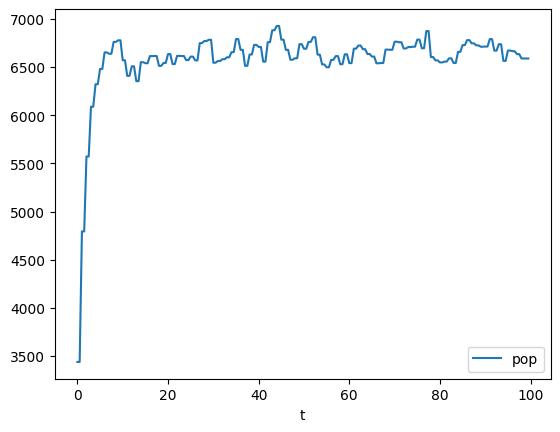

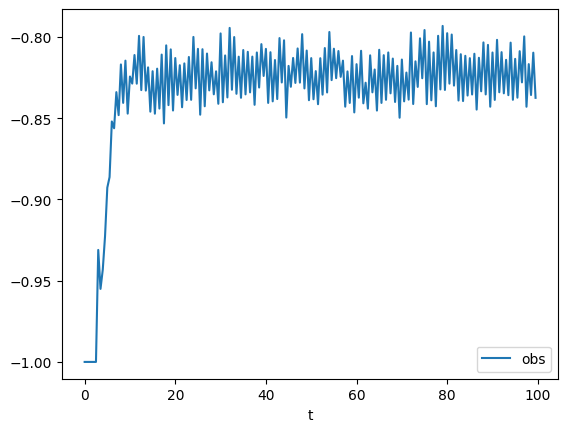

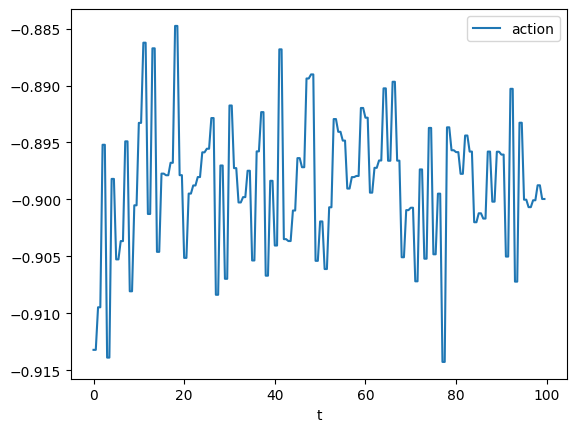

In [13]:
# area to focus: .loc[ a : b ]
a=0
b=200
print(sum(summary_df.rew))
summary_df.loc[ a : b ].plot(x='t', y='pop')
summary_df.loc[ a : b ].plot(x='t', y='obs')
summary_df.loc[ a : b ].plot(x='t', y='action')

In [38]:
# summary_df.plot(x='obs', y='action', kind='scatter')